In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [5]:
class WebScraper:
    def __init__(self, db_name="scraper_data.db"):
        self.db_name = db_name
        self.links = []

        self.conn = sqlite3.connect(self.db_name)
        self.cursor = self.conn.cursor()
        self._initialize_db()

    def _initialize_db(self):
        create_table_query = """
        CREATE TABLE IF NOT EXISTS links (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            text TEXT NOT NULL,
            url TEXT NOT NULL
        )
        """
        self.cursor.execute(create_table_query)
        self.conn.commit()
    def fetch_page(self, url, headers=None):
        headers = headers or {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36"
        }
        time.sleep(2)
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            print("ページの取得成功")
            return response.text
        else:
            raise Exception(f"ページの取得失敗: {response.status_code}")

    def extract_links(self, html):
        soup = BeautifulSoup(html, "html.parser")
        for link in soup.find_all("a"):
            href = link.get("href")
            text = link.get_text(strip=True)
            if href and text:
                self.links.append({"text": text, "url": href})
        print(f"{len(self.links)} 件のリンクを抽出しました")
    def save_to_db(self):
        insert_query = "INSERT INTO links (text, url) VALUES (?, ?)"
        self.cursor.executemany(insert_query, [(link['text'], link['url']) for link in self.links])
        self.conn.commit()
        print(f"{len(self.links)} 件のデータをデータベースに保存しました")

    def query_data(self, query):
        return pd.read_sql_query(query, self.conn)

    def analyze_text_length(self, df):
        df['text_length'] = df['text'].apply(len)
        plt.figure(figsize=(10, 6))
        sns.histplot(df['text_length'], bins=20, kde=True, color="skyblue")
        plt.title("Distribution of Link Text Length", fontsize=16)
        plt.xlabel("Text Length", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def analyze_domains(self, df):
        def extract_domain(url):
            try:
                return url.split('/')[2]
            except IndexError:
                return None

        df['domain'] = df['url'].apply(extract_domain)
        domain_counts = df['domain'].value_counts().head(10)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=domain_counts.index, y=domain_counts.values, palette="viridis")
        plt.title("Top 10 Domains by Frequency", fontsize=16)
        plt.xlabel("Domain", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def close_connection(self):
        self.conn.close()


        

ページの取得成功
201 件のリンクを抽出しました
201 件のデータをデータベースに保存しました
取得したデータ:
   id    text               url
0   1  �k�C��   /travel/010000/
1   2    ���k  /travel/pro_002/
2   3     �X   /travel/020000/
3   4     ���   /travel/030000/
4   5    �{��   /travel/040000/


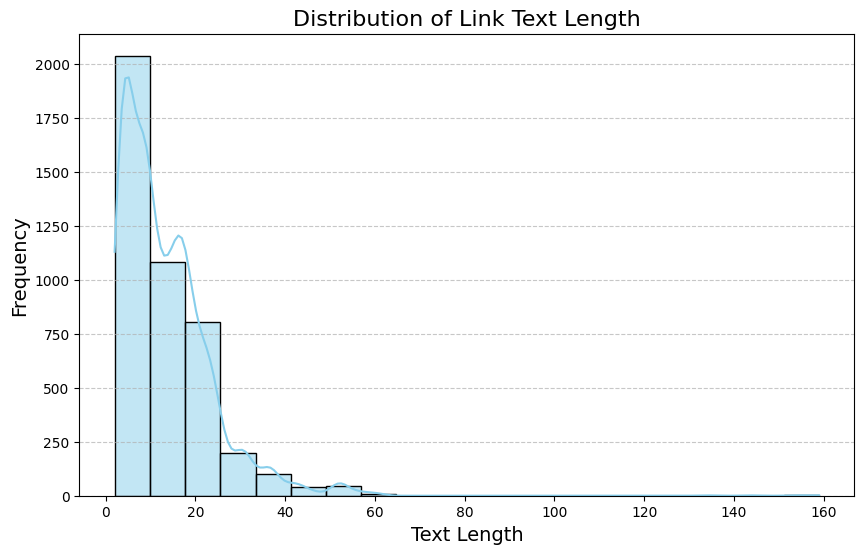

/var/folders/rt/1rqz8skn1r7fzd8l2rb10f_40000gn/T/ipykernel_78088/2192549609.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.index, y=domain_counts.values, palette="viridis")


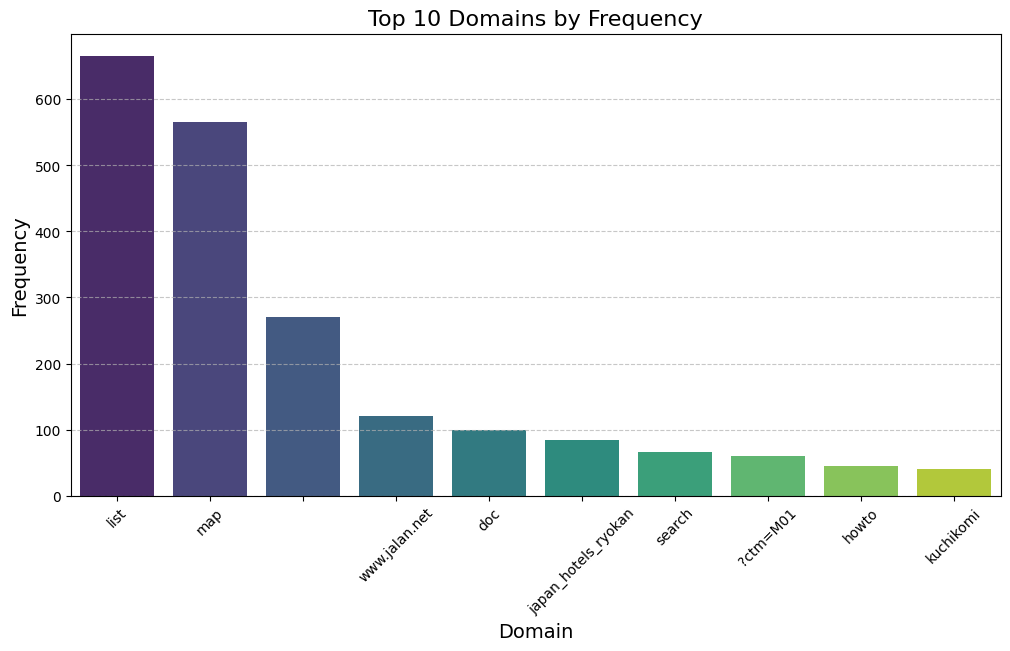

In [6]:
# 動的に処理するための関数
def run_scraper():
    url = input("スクレイピングするURLを入力してください: ")
    scraper = WebScraper()

    try:
        # データ収集
        html = scraper.fetch_page(url)
        scraper.extract_links(html)
        scraper.save_to_db()

        # データ取得と分析
        query = input("分析に使用するSQLクエリを入力してください（例: SELECT * FROM links）: ")
        df = scraper.query_data(query)
        print(f"取得したデータ:\n{df.head()}")

        # 分析
        scraper.analyze_text_length(df)
        scraper.analyze_domains(df)

    finally:
        scraper.close_connection()

if __name__ == "__main__":
    run_scraper()
    

URL : https://www.jalan.net/

SQLクエリ : SELECT * FROM links;